In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy


# 血管壁の動きの支配方程式：

$$\partial_t h_1= d_h \partial_{x}^2 h_1 + \sigma \eta_1(x,t) -k_s/w_1\big(h_1-(H-w)\big)+k_e/(2r)(h_2-h_1+2r)$$
$$\partial_t h_2= d_h \partial_{x}^2 h_2 + \sigma \eta_2(x,t) -k_e/(2r)(h_2-h_1+2r)+k_s/w_2(h_3-h_2+w_2)$$

$$\partial_t h_3= d_h \partial_{x}^2 h_3 + \sigma \eta_3(x,t) -k_s/w_2(h_3-h_2+w_2)+k_e/(2r)(h_4-h_3+2r)$$
$$\partial_t h_4= d_h \partial_{x}^2 h_4 + \sigma \eta_4(x,t) -k_e/(2r)(h_4-h_3+2r)-k_s/w_1(h_4+H-w_1)$$

* $h_i(x,t)$: 時刻$t$で場所$x$の$i$番目の血管の界面の位置
* $d_h$: 血管壁の表面張力。炎症時には細胞間接着が外れて減少する
* $\sigma$: 内皮細胞のランダムな運動の強さ
* $\eta_i(x,t)$: 平均0，分散1の正規分布の乱数（標準正規乱数）
* $k_s$: 周辺の結合組織の硬さ（単位長さあたりのバネ係数）
* $k_e$: 血管壁同士の相互作用の単位長さあたりのバネ係数
* $H$: 血管系全体の高さの範囲
* $w_1$: 血管と表皮の間の間隔
* $w_2$: 血管同志の間の間隔
* $r$: 血管の半径



In [11]:
def TwoVesselModel(L=5, dh=1, sigma=1, ks=0.1, ke=0.1, w1=1, w2=2,r=0.5, fps=20, T=1000, progress=True):
    H=w2/2+2*r+w1
    print(H)
    dx=0.1
    dt=0.001
    sqrt_dt = np.sqrt(dt)

    n = int(L/dx)
    loop = int(T/dt)
    loopPerOutput = int(T/dt/100)

    def Delta(h):
        return (np.roll(h,1)+np.roll(h,-1)-2*h)/dx/dx

    hList = []
    h1 = np.zeros(n)+w2/2+2*r
    h1New = deepcopy(h1)
    h2 = np.zeros(n)+w2/2
    h2New =deepcopy(h2)
    h3 = np.zeros(n)-w2/2
    h3New=deepcopy(h3)
    h4 = np.zeros(n)-w2/2-2*r
    h4New=deepcopy(h4)

    for t in tqdm(range(loop)):

        h1New += (dt*(
            -ks/w1*(h1-(H-w1))+ke/(2*r)*(h2-h1+2*r)
            +dh*Delta(h1)
            )+sigma * np.random.randn(n) * sqrt_dt)

        h2New += (dt*(
            -ke/(2*r)*(h2-h1+2*r)+ks/w2*(h3-h2+w2)
            +dh*Delta(h2)
            )+sigma * np.random.randn(n) * sqrt_dt)

        h3New += (dt*(
            -ks/w2*(h3-h2+w2)+ke/(2*r)*(h4-h3+2*r)
            +dh*Delta(h3)
            )+sigma * np.random.randn(n) * sqrt_dt)

        h4New += (dt*(
            -ke/(2*r)*(h4-h3+2*r)-ks/w1*(h4+H-w1)
            +dh*Delta(h4)
            )+sigma * np.random.randn(n) * sqrt_dt)  

        h1 = deepcopy(h1New)
        h1[0]=h1[-1]=w2/2+2*r
        h1[h1 > H] = H
        h2 = deepcopy(h2New)
        h2[0]=h2[-1]=w2/2
        h3 = deepcopy(h3New)
        h3[0]=h3[-1]=-w2/2
        h4 = deepcopy(h4New)
        h4[h4 < -H] = -H
        h4[0]=h4[-1]=-w2/2-2*r

        if t % loopPerOutput == 0:
            hList.append([h1,h2,h3,h4])
    return hList


In [12]:
def plotVessel(h, ax=None):
    ax = ax if ax is not None else plt.gca()
    ax.plot(h[0], color='red')
    ax.plot(h[1], color='red')
    ax.plot(h[2], color='red')
    ax.plot(h[3], color='red')
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal')
    ax.fill_between(range(len(h[0])), h[0], h[1], color='red', alpha=0.2)
    ax.fill_between(range(len(h[2])), h[2], h[3], color='red', alpha=0.2)
    if ax is plt.gca():
        plt.show()




3.0


100%|██████████| 100000/100000 [00:09<00:00, 10979.46it/s]

ks=10


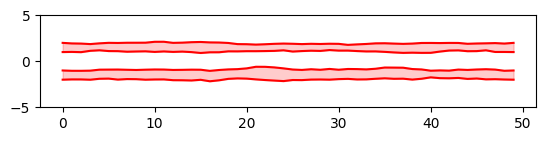

3.0


100%|██████████| 100000/100000 [00:09<00:00, 11050.10it/s]


ks=0


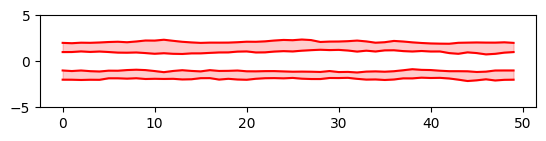

In [21]:
for ks in [10,0]:
    result=TwoVesselModel(ks=ks,ke = 1, sigma = 1, T=100)
    print(f"ks={ks}")
    plotVessel(result[-1])


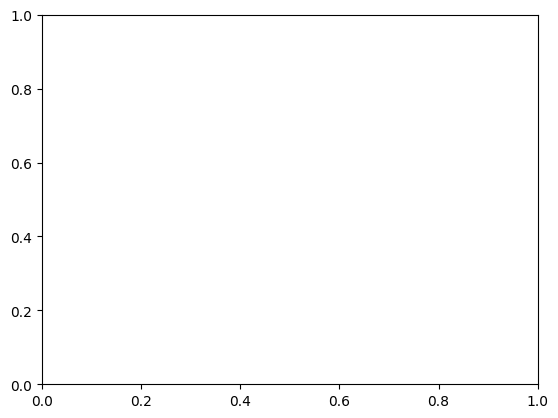

In [22]:
from matplotlib import animation
from IPython.display import HTML, display

fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    plotVessel(result[i], ax=ax)
    ax.set_title(f"Frame {i}")

ani = animation.FuncAnimation(fig, animate, frames=len(result), interval=50, repeat=False)
plt.close(fig)  # Prevents duplicate static plot in Jupyter
display(HTML(ani.to_jshtml()))


In [ ]:
0.1,1,0.001,0.1

(0.1, 1, 0.001, 0.1)

In [ ]:
def export_vessel_animation(dh=0.1, sigma=1, ks=0.001, ke=0.1, w1=1,w2=2,r=0.5, T=100, fps=20):
    """
    引数で与えた dh, sigma, ks, ke を用いてシミュレーションし、
    形態変化のアニメーションを MP4 で保存する（ノートブックには出さない）。
    保存ファイル名はパラメータ入りで自動命名。
    """
    from matplotlib import animation
    import matplotlib.pyplot as plt

    # インタラクティブ表示を抑止
    prev_interactive = plt.isinteractive()
    plt.ioff()
    try:
        # 進捗バーも抑止
        result = TwoVesselModel(dh=dh, sigma=sigma, ks=ks, ke=ke, w1=w1, w2=w2,r=r,T=T, fps=20,  progress=False)

        filename = f"vessel_dh{dh}_sigma{sigma}_ks{ks}_ke{ke}.mp4"
        fig, ax = plt.subplots()

        def animate(i):
            ax.clear()
            plotVessel(result[i], ax=ax)
            ax.set_title(f"Frame {i}")

        ani = animation.FuncAnimation(fig, animate, frames=len(result), interval=1000.0/fps, repeat=False)

        try:
            from matplotlib.animation import FFMpegWriter
            writer = FFMpegWriter(fps=fps, metadata=dict(artist=''), bitrate=1800)
            ani.save(filename, writer=writer)
        except Exception:
            ani.save(filename, writer='ffmpeg', fps=fps)
        finally:
            plt.close(fig)
    finally:
        plt.interactive(prev_interactive)

    return filename


3.0


100%|██████████| 100/100 [00:06<00:00, 14.70it/s]


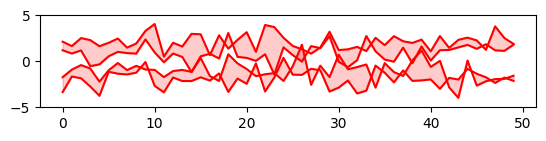

'vessel_dh0.1_sigma1_ks0.001_ke0.1.mp4'

In [ ]:
export_vessel_animation()

3.0


100%|██████████| 100/100 [00:06<00:00, 14.67it/s]


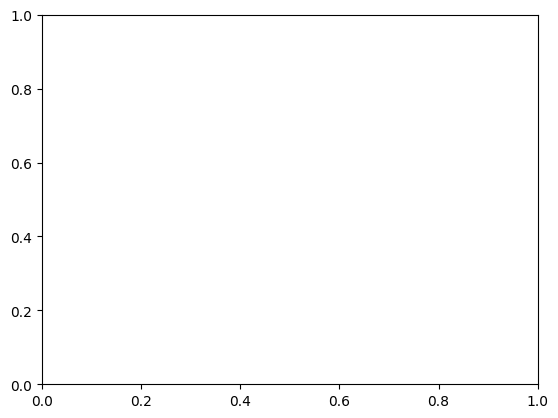

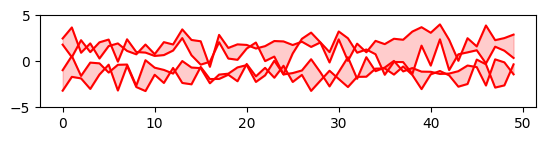

'vessel_dh0.1_sigma1_ks0.1_ke0.1.mp4'

In [ ]:
export_vessel_animation(0.1,1,0.1,0.1)

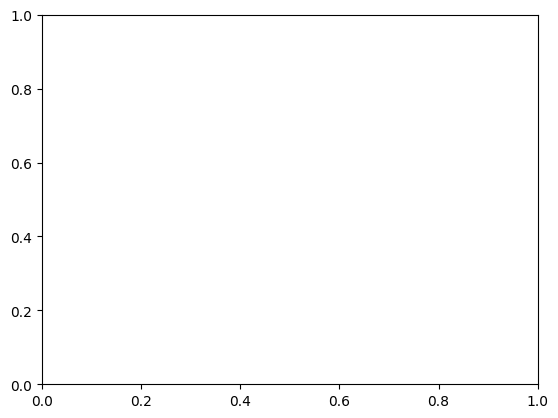

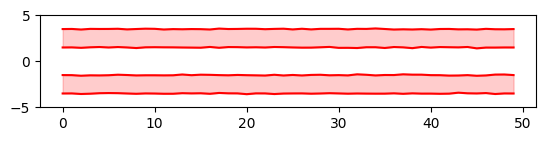

'vessel_dh1.0_sigma1_ks0.1_ke0.1.mp4'

In [ ]:
export_vessel_animation(1.0,1,0.1,0.1)

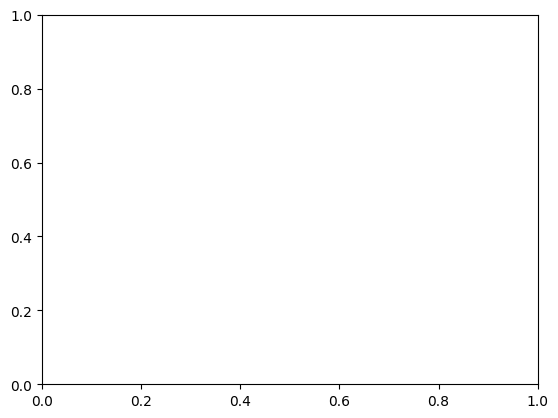

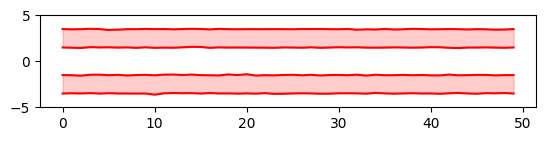

'vessel_dh0.1_sigma1_ks1.0_ke0.1.mp4'

In [ ]:
export_vessel_animation(0.1,1,1.0,0.1)

In [ ]:
resultList = []
for i in range(100):
    result=TwoVesselModel(T=100)
    resultList.append(result)


100%|██████████| 100000/100000 [00:08<00:00, 12224.48it/s]


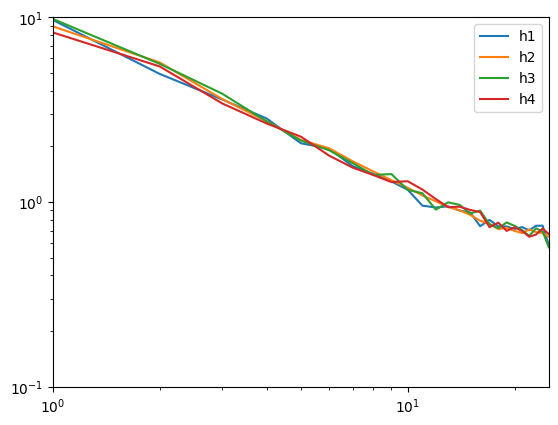

In [ ]:
h1hatList = []
h2hatList = []
h3hatList = []
h4hatList = []
for i in range(100):
    h1hatList.append(np.abs(np.fft.fft(resultList[i][-1][0])))
    h2hatList.append(np.abs(np.fft.fft(resultList[i][-1][1])))
    h3hatList.append(np.abs(np.fft.fft(resultList[i][-1][2])))
    h4hatList.append(np.abs(np.fft.fft(resultList[i][-1][3])))

h1hatMean = np.array(h1hatList).mean(axis=0)
h2hatMean = np.array(h2hatList).mean(axis=0)
h3hatMean = np.array(h3hatList).mean(axis=0)
h4hatMean = np.array(h4hatList).mean(axis=0)

#h1hatMean = h1hatMean - h1hatMean.mean()
#h2hatMean = h2hatMean - h2hatMean.mean()
#h3hatMean = h3hatMean - h3hatMean.mean()
#h4hatMean = h4hatMean - h4hatMean.mean()

plt.plot(h1hatMean)
plt.plot(h2hatMean)
plt.plot(h3hatMean)
plt.plot(h4hatMean)
plt.xlim(1,25)
plt.ylim(0.1,10)
plt.xscale('log')
plt.yscale('log')
plt.legend(["h1","h2","h3","h4"])
plt.show()




In [ ]:
[h1hatMean[0],h2hatMean[0],h3hatMean[0],h4hatMean[0]]

[np.float64(174.1325970060872),
 np.float64(76.06408879506286),
 np.float64(75.00517921280601),
 np.float64(174.0684267036438)]

In [ ]:
[resultList[0][-1][0].mean(), resultList[0][-1][1].mean(),
resultList[0][-1][2].mean(),resultList[0][-1][3].mean()]

[np.float64(4.125102291599593),
 np.float64(2.3631877110360118),
 np.float64(-1.1264919001178013),
 np.float64(-3.363782342188161)]

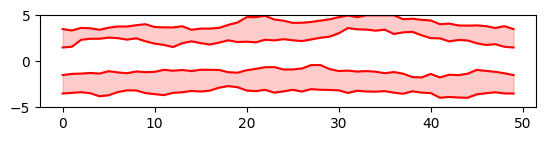

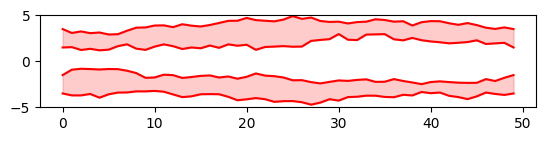

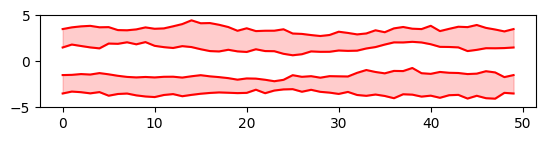

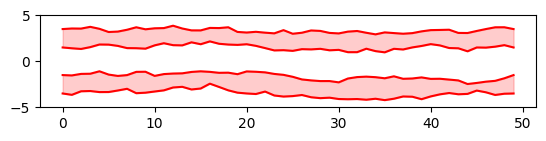

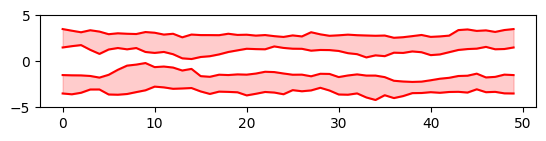

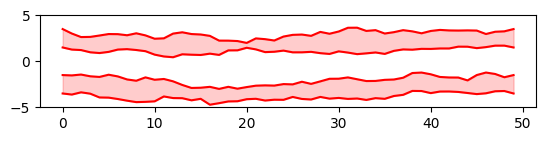

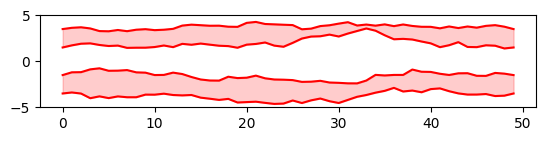

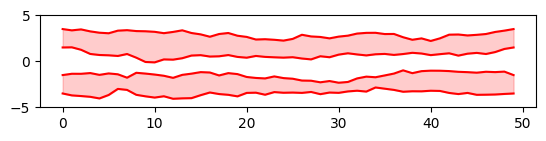

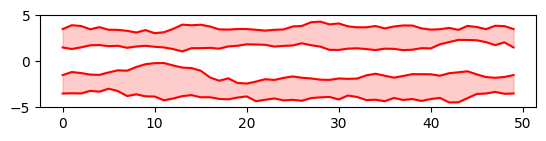

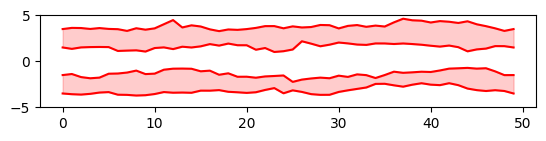

In [ ]:
for i in range(10):
    plotVessel(resultList[i][-1])